In [106]:
from sys import path
path.insert(0, '..')
from os.path import exists
import numpy as np
import matplotlib.pyplot as plt
import trainer.data as D
import trainer.tools as tl

In [107]:
def iter_data(X, Y):
    num_channels, num_samples, len_seq = X.shape
    for i in range(num_samples):
        yield X[:, i, :], Y[i]

def decode(xvec):
    return D.decode(np.argmax(xvec))

# Plot data

Plot .tfrecords-file

In [108]:
import glob
import numpy as np
tfrfiles = glob.glob('../datasets/tfrecords/*tfrecords')
channels = D.channels
fname = '../datasets/tfrecords/brux2.tfrecords'
data = D.read_tfrecords(f=fname)
target = data.pop('target')

i = 0
def iter_data_dict(data, target):
    i = -1
    while True:
        i += 1
        yield {c: d[i] for c, d in data.items()}, target[i]

it = iter_data_dict(data, target)

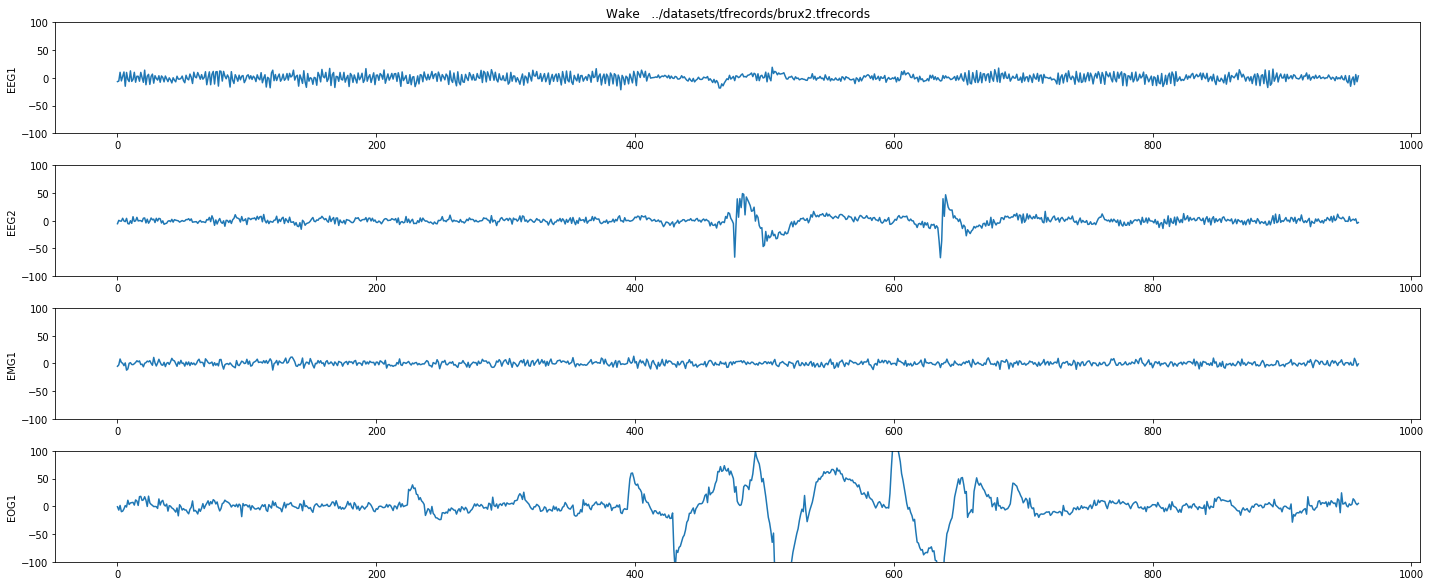

In [109]:
x, y = next(it)
fig = plt.figure(figsize=(20, 10))
for c, (name, segment) in enumerate(x.items()):
    plt.subplot(511+c)
    if c == 0:
        plt.title(f"{decode(y)}   {fname}")        
    plt.plot(segment)
    plt.ylabel(name)
    plt.ylim(-100, 100)
plt.tight_layout()
plt.show()

# Analysis of CNN

## Load/save model as keras

In [110]:
from trainer import model as M
import numpy as np
import trainer.data as D
import matplotlib.pyplot as plt
import keras


augment = '0.4'
split = 0
ckpt = 7000
DIR = '../logs/cross_val/augment_%s/split_%i/'%(augment, split)
modelfile = DIR+'ckpt-%i.h5'%ckpt
assert exists(modelfile), modelfile

In [111]:
def plot_traces_and_surrogate_analysis(X, P, P_surrogates):
    """
    Arguments:
        X: Signals of surrogate data
        P: Class Probabilities of epoch X
        P_surrgates: Class probabilities of X with partial augmentation
    """
    assert X.shape == (4, 960), X.shape
    assert P.size == 6, P.shape 
    assert P_surrogates.shape == (96, 6), P_surrogates.shape 
    fig = plt.figure(figsize=(8, 5))
    ax = None
    t = np.arange(X.shape[1])/D.sr
    for c, (channel, x) in enumerate(zip(D.channels, X)):
        ax = plt.subplot2grid((6, 1), ( c, 0), sharex=ax)
        plt.plot(t, x, 'r-', lw=1.0)
        plt.ylabel(channel, fontsize=12)
        plt.grid()
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    
    plt.subplot2grid((6, 1), (4, 0), rowspan=2, sharex=ax)
    t = np.arange(P_surrogates.shape[0])/D.sr*stride
    plt.axhline(y=(np.max(P)), color='k', ls='--')
    for i, stage in enumerate(D.events):
        if stage not in ('S2', 'REM'):
            continue
        plt.semilogy(t, (P_surrogates[:, i]), lw=2.0, label=stage)
    plt.legend(fontsize=12)
    plt.grid()
    plt.xlim(t[0], t[-1])
    plt.ylim(-2, 1)#-1.5, 0.1)
    plt.ylabel('log(P)', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.03)
    plt.show()

In [112]:
def read_records(filename='../datasets/tfrecords/ins2.tfrecords'):
    record = D.read_tfrecords(filename)
    features = {
        tp: record[tp] for tp in D.channels
    }
    target = record['target']
    one_hot = keras.utils.to_categorical(target, num_classes=6)
    return features, target, one_hot

Load keras model

In [113]:
model = keras.models.load_model(modelfile, custom_objects={'Scale': M.Scale})
features, target, one_hot = read_records('../datasets/tfrecords/nfle12.tfrecords')
# model.summary()
proba = model.predict(features)
y_pred = proba.argmax(axis=1)
'acc', np.mean(target == y_pred)

/Users/ascakmak/anaconda2/envs/asc_py3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


('acc', 0.7502347417840376)

True label: REM

P(Wake) = 1%
P(S1) = 7%
P(S2) = 68%
P(S3) = 0%
P(S4) = 0%
P(REM) = 24%


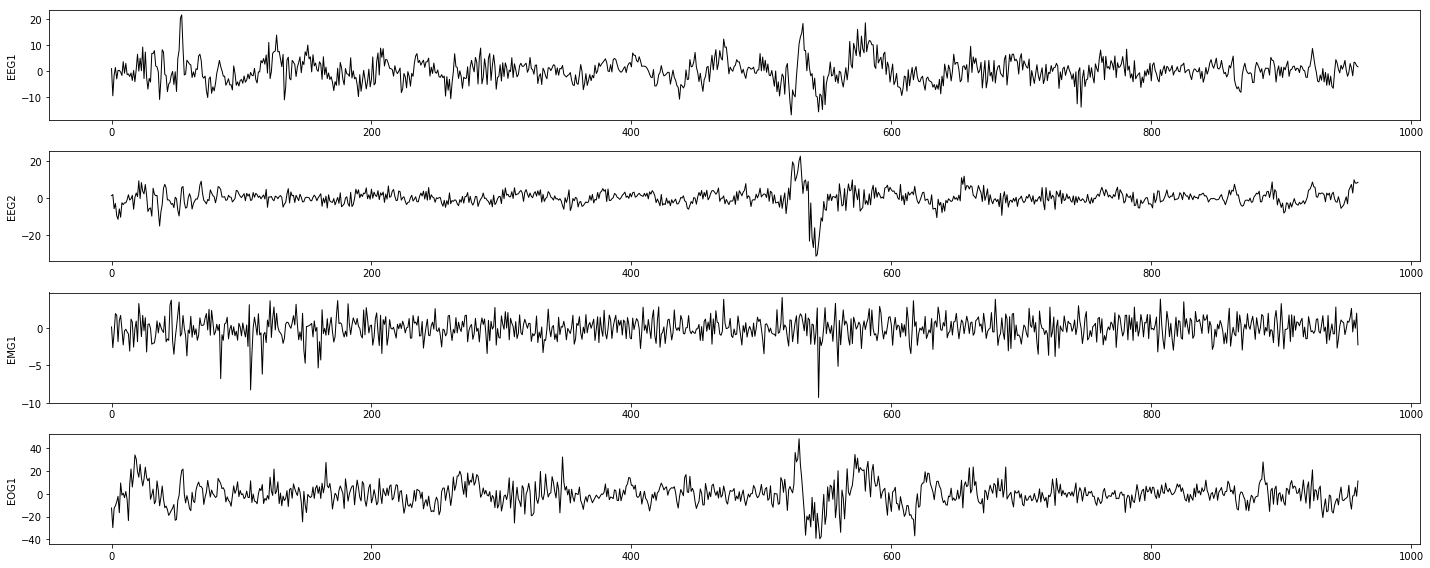

In [114]:
epoch_num = 154
X = [features[ch][epoch_num][None,:] for ch in D.channels]
original = np.array([features[ch][epoch_num][None,:] for ch in D.channels])
label = D.events[target[epoch_num]]
P = proba[epoch_num]
print('True label:', label)
print()
for stage, p in zip(D.events, P):
    print(f"P({stage}) = {100*p:.0f}%")

plt.figure(figsize=(20, 8))
ax = None
for c, channel in enumerate(D.channels):
    ax = plt.subplot(411+c, sharex=ax)
    plt.plot(X[c][0], 'k-', lw=1)
    plt.ylabel(channel)
    
plt.tight_layout()
plt.show()


# Zero out part of the signal

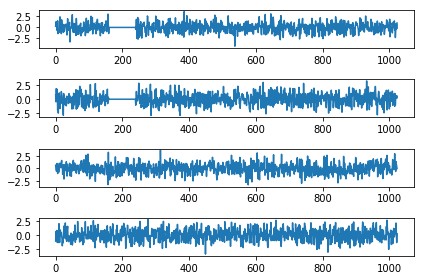

In [115]:
def zero_out(X, stride=1, channels=None, width=2.5):
    if not isinstance(width, int):
        width = int(D.sr * width)
    width2 = width//2
    num_channels, num_samples = X.shape
    if channels is None:
        channels = slice(0, num_channels)
    else:
        channels = [D.channels.index(c) for c in channels]
    
    repeats = 1+num_samples//stride
    Y = np.repeat(X, repeats).reshape(-1, repeats).transpose().reshape(
        repeats, num_channels, -1)
    for i, s in enumerate(range(0, num_samples, stride)):
        s = slice(max(0, s-width2), min(num_samples-1, s+width2))
        Y[i, channels, s] = 0.0
    return Y.swapaxes(0, 1)

X_rnd = np.random.randn(4, 1024)
X_rnd = zero_out(X_rnd, stride=100, channels=['EEG1', 'EEG2'])

for i, x in enumerate(X_rnd):
    plt.subplot(411+i)
    plt.plot(x[2])
plt.tight_layout()    
plt.show()

In [116]:
stride = 10
Xin = np.array([X[c][0] for c, _ in enumerate(D.channels)])
Xcut = zero_out(Xin, stride=stride, width=5.0)
P_cut = model.predict(list(Xcut))

In [117]:
print(f'True label: {label} (prediction {D.events[P.argmax()]})')

True label: REM (prediction S2)


/Users/ascakmak/anaconda2/envs/asc_py3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


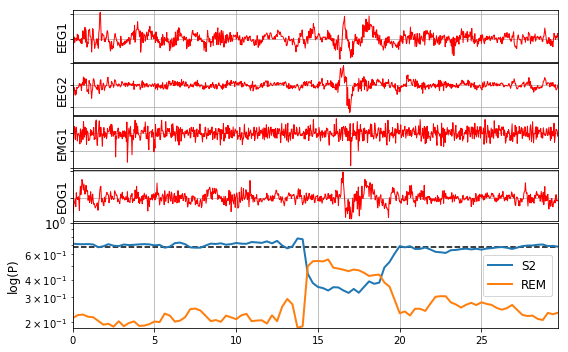

In [118]:
plot_traces_and_surrogate_analysis(np.asarray(X).squeeze(), P, P_cut[:96])

## Replace part of signal with FFT-surrogate data

../trainer/tools.py:428: ComplexWarning: Casting complex values to real discards the imaginary part
  return shifted.astype(np.float64)


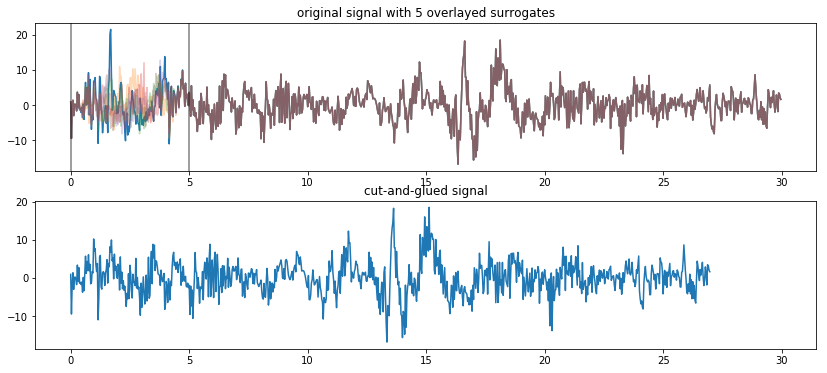

In [119]:
duration = 5.0 #sec
start = 0.0 # sec
end = start+duration # sec
transition = 2.0 #sec
x = X[0][0]
t = np.arange(x.shape[0])/D.sr
# xs = tl.partial_fft_surrogate_batch(x, 10, start, end, transition, sr=D.sr)
xs = tl.partial_fft_surrogate(x, start, end, transition, sr=D.sr)
c = tl.cut_and_glue(x, start, end, transition, sr=D.sr)
plt.figure(figsize=(14, 6))
ax = plt.subplot(211)
plt.title(f'original signal with {xs.shape[0]} overlayed surrogates')
plt.plot(t, x)
for xi in xs:
    plt.plot(t, xi, alpha=0.3)
plt.axvline(x=start, color='k', alpha=.5)
plt.axvline(x=end, color='k', alpha=.5)

plt.subplot(212, sharex=ax)
plt.title('cut-and-glued signal')
plt.plot(np.arange(c.size)/D.sr, c)
plt.show()

In [120]:
stride = 10
P = proba[epoch_num]
Xin = np.array([X[c][0] for c, _ in enumerate(D.channels)])
surrogate_batches = tl.generate_partial_surrogate_batches(
    Xin, batch_size=50, stride=stride, width=5.0, channels=['EEG1', 'EEG2'], transition=1.0, sr=D.sr)

../trainer/tools.py:428: ComplexWarning: Casting complex values to real discards the imaginary part
  return shifted.astype(np.float64)


In [121]:
P_surrogates = np.array([
    model.predict(list(batch)).mean(axis=0)
    for batch in surrogate_batches
])

/Users/ascakmak/anaconda2/envs/asc_py3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


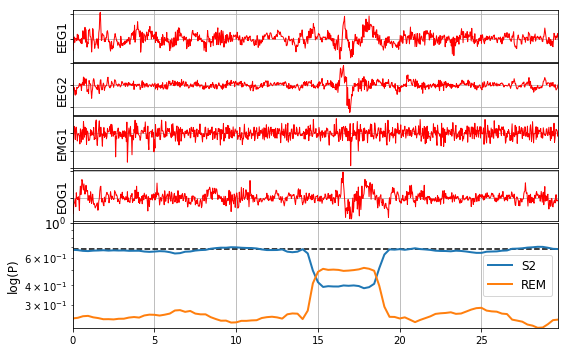

In [122]:
plot_traces_and_surrogate_analysis(np.asarray(X).squeeze(), P, P_surrogates)